<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.1.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [2]:
data=pd.read_csv('ner_dataset.csv',encoding='latin1')
data=data.fillna(method="ffill")
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
print("unique words in corrpus:",data['Word'].nunique())
print("uniquetags in corpus:",data['Tag'].nunique())

unique words in corrpus: 35178
uniquetags in corpus: 17


In [4]:
words=list(set(data["Word"].values))
words.append("ENDPAD")
num_words=len(words)

In [5]:
tags=list(set(data["Tag"].values))
num_tags=len(tags)

In [6]:
num_words,num_tags

(35179, 17)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [7]:
class SentenceGetter(object):
    def __init__(self,data):
        self.n_sent=1
        self.data=data
        agg_func=lambda s:[(w,p,t) for w,p,t in zip(s["Word"].values.tolist(),s["POS"].values.tolist(),s['Tag'].values.tolist())]
        self.grouped=self.data.groupby("Sentence #").apply(agg_func)
        self.sentences=[s for s in self.grouped]
        

In [8]:
getter=SentenceGetter(data)
sentences=getter.sentences

In [9]:
sentences[0] #list containing tuples that has three values for 1st sentence

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [10]:
word2idx={w:i+1 for i , w in enumerate(words)} #i+1 as we created endpad 
tag2idx={t:i for i,t in enumerate(tags)}
    

In [11]:
tag2idx

{'I-art': 0,
 'B-eve': 1,
 'I-geo': 2,
 'I-org': 3,
 'B-tim': 4,
 'O': 5,
 'B-org': 6,
 'I-tim': 7,
 'I-per': 8,
 'B-nat': 9,
 'I-nat': 10,
 'B-per': 11,
 'I-eve': 12,
 'I-gpe': 13,
 'B-art': 14,
 'B-geo': 15,
 'B-gpe': 16}

### Task 5: Padding Input Sentences and Creating Train/Test Splits

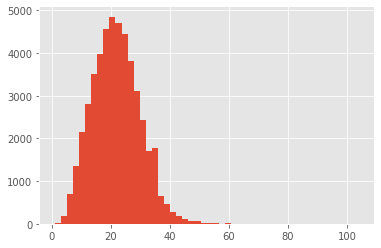

In [12]:
plt.hist([len(s) for s in sentences],bins=50) #histogram of length of sentences
plt.show()

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len= 50
X= [[word2idx[w[0]] for w in s ] for s in sentences]

In [14]:
X=pad_sequences(maxlen=max_len,sequences=X,padding="post", value=num_words-1) #feature vectors

#target vector
y=[[tag2idx[w[2]] for w in s ] for s in sentences]
y=pad_sequences(maxlen=max_len,sequences=y,padding="post",value=tag2idx["O"])
y=[to_categorical(i,num_classes=num_tags) for i in y]

In [15]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.1,random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [16]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [17]:
input_word=Input(shape=(max_len,)) #input layer
model=Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len)(input_word)
model= SpatialDropout1D(0.1)(model) #regularization
model=Bidirectional(LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(model) #bidirectional so that model learns across the entire sequence
out=TimeDistributed(Dense(num_tags,activation="softmax"))(model)
model=Model(input_word,out)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])

### Task 7: Train the Model

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [20]:
early_stopping=EarlyStopping(monitor="val_accuracy",patience=1,verbose=0,mode='max',restore_best_weights=False)
callbacks=[PlotLossesCallback(),early_stopping]

history=model.fit(xtrain,np.array(ytrain),validation_split=0.2,batch_size=32,epochs=3,verbose=1)

Train on 34530 samples, validate on 8633 samples
Epoch 1/3
34530/34530 [==============================] - 209s 6ms/sample - loss: 0.1899 - accuracy: 0.9565 - val_loss: 0.0687 - val_accuracy: 0.9804
Epoch 2/3
34530/34530 [==============================] - 205s 6ms/sample - loss: 0.0541 - accuracy: 0.9841 - val_loss: 0.0513 - val_accuracy: 0.9844
Epoch 3/3
34530/34530 [==============================] - 205s 6ms/sample - loss: 0.0393 - accuracy: 0.9880 - val_loss: 0.0477 - val_accuracy: 0.9855


### Task 8: Evaluate Named Entity Recognition Model

In [21]:
model.evaluate(xtest,np.array(ytest))

4796/4796 [==============================] - 6s 1ms/sample - loss: 0.0503 - accuracy: 0.9848


[0.05031893374375048, 0.9848415]

In [27]:
i =np.random.randint(0,xtest.shape[0]) #to take the rndom values from the test
p=model.predict(np.array([xtest[i]]))

p=np.argmax(p,axis=-1) 


y_true=np.argmax(np.array(ytest),axis=-1)[i]

print("{:15}{:5}\t {}\n".format("word","True","pred"))
print("-"*30)

for w,true,pred in zip(xtest[i],y_true,p[0]):
    print("{:15}{}\t{}".format(words[w-1],tags[true],tags[pred]))

word           True 	 pred

------------------------------
Fighting       O	O
between        O	O
largely        O	O
Arab           B-gpe	B-gpe
pro-government O	O
militias       O	O
and            O	O
non-Arab       O	O
rebels         O	O
in             O	O
Darfur         B-geo	B-geo
has            O	O
left           O	O
tens           O	O
of             O	O
thousands      O	O
dead           O	O
,              O	O
including      O	O
many           O	O
civilians      O	O
.              O	O
]              O	O
]              O	O
]              O	O
]              O	O
]              O	O
]              O	O
]              O	O
]              O	O
]              O	O
]              O	O
]              O	O
]              O	O
]              O	O
]              O	O
]              O	O
]              O	O
]              O	O
]              O	O
]              O	O
]              O	O
]              O	O
]              O	O
]              O	O
]              O	O
]              O	O
]              O	O
]            